<a href="https://colab.research.google.com/github/deepsatflow/ColabDesign/blob/main/af/examples/peptide_binder_design.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AfDesign - peptide binder design
For a given protein target and protein binder length, generate/hallucinate a protein binder sequence AlphaFold thinks will bind to the target structure. To do this, we maximize number of contacts at the interface and maximize pLDDT of the binder.

**WARNING**
1.   This notebook is in active development and was designed for demonstration purposes only.
2.   Using AfDesign as the only "loss" function for design might be a bad idea, you may find adversarial sequences (aka. sequences that trick AlphaFold).

In [1]:
#@title **setup**
import os
if not os.path.isdir("params"):
  # get code
  os.system("pip -q install git+https://github.com/sokrypton/ColabDesign.git@v1.1.1")
  # for debugging
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabdesign colabdesign")
  # download params
  os.system("mkdir params")
  os.system("apt-get install aria2 -qq")
  os.system("aria2c -q -x 16 https://storage.googleapis.com/alphafold/alphafold_params_2022-12-06.tar")
  os.system("tar -xf alphafold_params_2022-12-06.tar -C params")

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
from colabdesign import mk_afdesign_model, clear_mem
from colabdesign.shared.utils import copy_dict
from colabdesign.af.alphafold.common import residue_constants

from IPython.display import HTML
from google.colab import files
import numpy as np

#########################
def get_pdb(pdb_code=""):
  if pdb_code is None or pdb_code == "":
    upload_dict = files.upload()
    pdb_string = upload_dict[list(upload_dict.keys())[0]]
    with open("tmp.pdb","wb") as out: out.write(pdb_string)
    return "tmp.pdb"
  elif os.path.isfile(pdb_code):
    return pdb_code
  elif len(pdb_code) == 4:
    os.system(f"wget -qnc https://files.rcsb.org/view/{pdb_code}.pdb")
    return f"{pdb_code}.pdb"
  else:
    os.system(f"wget -qnc https://alphafold.ebi.ac.uk/files/AF-{pdb_code}-F1-model_v3.pdb")
    return f"AF-{pdb_code}-F1-model_v3.pdb"

In [2]:
#@title **prep inputs**
import re
#@markdown ---
#@markdown **target info**
pdb = "" #@param {type:"string"}
#@markdown - enter PDB code or UniProt code (to fetch AlphaFoldDB model) or leave blink to upload your own
target_chain = "A" #@param {type:"string"}
target_hotspot = "" #@param {type:"string"}
if target_hotspot == "": target_hotspot = None
#@markdown - restrict loss to predefined positions on target (eg. "1-10,12,15")
target_flexible = False #@param {type:"boolean"}
#@markdown - allow backbone of target structure to be flexible

#@markdown ---
#@markdown **binder info**
binder_len = 14 #@param {type:"integer"}
#@markdown - length of binder to hallucination
binder_seq = "" #@param {type:"string"}
binder_seq = re.sub("[^A-Z]", "", binder_seq.upper())
if len(binder_seq) > 0:
  binder_len = len(binder_seq)
else:
  binder_seq = None
#@markdown - if defined, will initialize design with this sequence

binder_chain = "B" #@param {type:"string"}
if binder_chain == "": binder_chain = None
#@markdown - if defined, supervised loss is used (binder_len is ignored)

#@markdown ---
#@markdown **model config**
use_multimer = True #@param {type:"boolean"}
#@markdown - use alphafold-multimer for design
num_recycles = 0 #@param ["0", "1", "3", "6"] {type:"raw"}
num_models = "2" #@param ["1", "2", "3", "4", "5", "all"]
num_models = 5 if num_models == "all" else int(num_models)
#@markdown - number of trained models to use during optimization


x = {"pdb_filename":pdb,
     "chain":target_chain,
     "binder_len":binder_len,
     "binder_chain":binder_chain,
     "hotspot":target_hotspot,
     "use_multimer":use_multimer,
     "rm_target_seq":target_flexible,
     }

x["pdb_filename"] = get_pdb(x["pdb_filename"])

if "x_prev" not in dir() or x != x_prev:
  clear_mem()
  model = mk_afdesign_model(protocol="binder",
                            use_multimer=x["use_multimer"],
                            num_recycles=num_recycles,
                            recycle_mode="sample")
  model.prep_inputs(**x,
                    rm_binder=False,
                    rm_binder_seq=True,
                    rm_binder_sc=True,
                    rm_template_ic=False,
                    ignore_missing=False)
  x_prev = copy_dict(x)
  print("target length:", model._target_len)
  print("binder length:", model._binder_len)
  binder_len = model._binder_len

Saving 7z14_l74_s134466_mpnn6_model2.pdb to 7z14_l74_s134466_mpnn6_model2.pdb
target length: 60
binder length: 74


In [3]:
#@title **run AfDesign**
from scipy.special import softmax

optimizer = "3stage" #@param ["pssm_semigreedy", "3stage", "semigreedy", "pssm", "logits", "soft", "hard"]
#@markdown - `pssm_semigreedy` - uses the designed PSSM to bias semigreedy opt. (Recommended)
#@markdown - `3stage` - gradient based optimization (GD) (logits → soft → hard)
#@markdown - `pssm` - GD optimize (logits → soft) to get a sequence profile (PSSM).
#@markdown - `semigreedy` - tries X random mutations, accepts those that decrease loss
#@markdown - `logits` - GD optimize logits inputs (continious)
#@markdown - `soft` - GD optimize softmax(logits) inputs (probabilities)
#@markdown - `hard` - GD optimize one_hot(logits) inputs (discrete)

#@markdown WARNING: The output sequence from `pssm`,`logits`,`soft` is not one_hot. To get a valid sequence use the other optimizers, or redesign the output backbone with another protocol like ProteinMPNN.

#@markdown ----
#@markdown #### advanced GD settings
GD_method = "sgd" #@param ["adabelief", "adafactor", "adagrad", "adam", "adamw", "fromage", "lamb", "lars", "noisy_sgd", "dpsgd", "radam", "rmsprop", "sgd", "sm3", "yogi"]
learning_rate = 0.1 #@param {type:"raw"}
norm_seq_grad = True #@param {type:"boolean"}
dropout = True #@param {type:"boolean"}

model.restart(seq=binder_seq)
model.set_optimizer(optimizer=GD_method,
                    learning_rate=learning_rate,
                    norm_seq_grad=norm_seq_grad)
models = model._model_names[:num_models]

flags = {"num_recycles":num_recycles,
         "models":models,
         "dropout":dropout}

if optimizer == "3stage":
  model.design_3stage(120, 60, 10, **flags)
  pssm = softmax(model._tmp["seq_logits"],-1)

if optimizer == "pssm_semigreedy":
  model.design_pssm_semigreedy(120, 32, **flags)
  pssm = softmax(model._tmp["seq_logits"],1)

if optimizer == "semigreedy":
  model.design_pssm_semigreedy(0, 32, **flags)
  pssm = None

if optimizer == "pssm":
  model.design_logits(120, e_soft=1.0, num_models=1, ramp_recycles=True, **flags)
  model.design_soft(32, num_models=1, **flags)
  flags.update({"dropout":False,"save_best":True})
  model.design_soft(10, num_models=num_models, **flags)
  pssm = softmax(model.aux["seq"]["logits"],-1)

O = {"logits":model.design_logits,
     "soft":model.design_soft,
     "hard":model.design_hard}

if optimizer in O:
  O[optimizer](120, num_models=1, ramp_recycles=True, **flags)
  flags.update({"dropout":False,"save_best":True})
  O[optimizer](10, num_models=num_models, **flags)
  pssm = softmax(model.aux["seq"]["logits"],-1)

model.save_pdb(f"{model.protocol}.pdb")

Stage 1: running (logits → soft)
1 models [0] recycles 0 hard 0 soft 0.01 temp 1 seqid 0.05 loss 296.09 dgram_cce 296.09 plddt 0.44 ptm 0.44 i_ptm 0.10 rmsd 35.01
2 models [1] recycles 0 hard 0 soft 0.02 temp 1 seqid 0.07 loss 250.40 dgram_cce 250.40 plddt 0.58 ptm 0.43 i_ptm 0.07 rmsd 17.05
3 models [0] recycles 0 hard 0 soft 0.03 temp 1 seqid 0.14 loss 234.34 dgram_cce 234.34 plddt 0.69 ptm 0.43 i_ptm 0.07 rmsd 35.87
4 models [0] recycles 0 hard 0 soft 0.03 temp 1 seqid 0.14 loss 225.54 dgram_cce 225.54 plddt 0.74 ptm 0.43 i_ptm 0.08 rmsd 34.49
5 models [0] recycles 0 hard 0 soft 0.04 temp 1 seqid 0.12 loss 233.45 dgram_cce 233.45 plddt 0.69 ptm 0.43 i_ptm 0.07 rmsd 36.24
6 models [1] recycles 0 hard 0 soft 0.05 temp 1 seqid 0.15 loss 210.13 dgram_cce 210.13 plddt 0.75 ptm 0.45 i_ptm 0.11 rmsd 10.11
7 models [1] recycles 0 hard 0 soft 0.06 temp 1 seqid 0.12 loss 195.31 dgram_cce 195.31 plddt 0.79 ptm 0.47 i_ptm 0.14 rmsd 5.87
8 models [1] recycles 0 hard 0 soft 0.07 temp 1 seqid 0.14

In [4]:
#@title display hallucinated protein {run: "auto"}
color = "pLDDT" #@param ["chain", "pLDDT", "rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}
color_HP = False #@param {type:"boolean"}
animate = True #@param {type:"boolean"}
model.plot_pdb(show_sidechains=show_sidechains,
               show_mainchains=show_mainchains,
               color=color, color_HP=color_HP, animate=animate)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

ValueError: RGBA values should be within 0-1 range

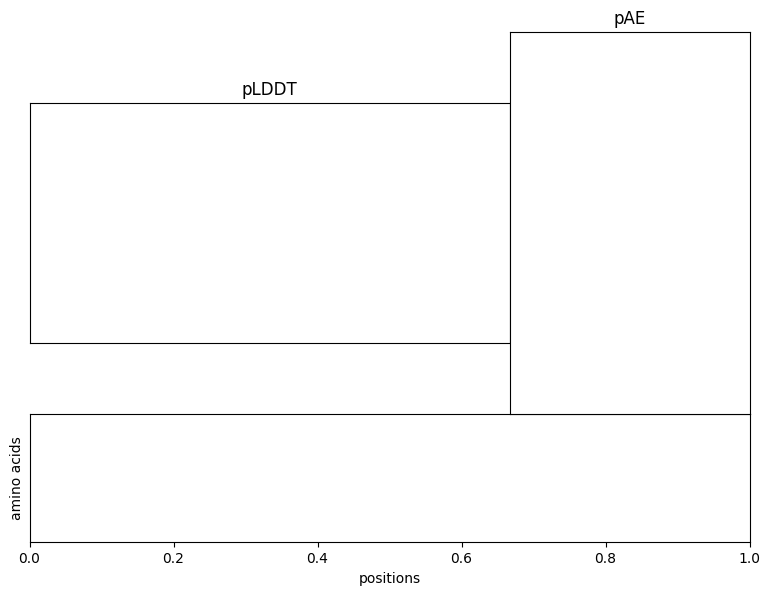

In [5]:
HTML(model.animate(dpi=100))

In [6]:
model.save_pdb(f"{model.protocol}.pdb")
model.get_seqs()

['PRAYGKSGGGSAQKFWRRMTPVMRKYRDGVWEKSDWEWDEGDRLMCKDVKFLPVMGFMQRIVHSPVERRGCHYF']

In [ ]:
#@markdown ### Amino acid probabilties
import plotly.express as px
alphabet = "ACDEFGHIKLMNPQRSTVWY"
if "pssm" in dir() and pssm is not None:
  fig = px.imshow(pssm.mean(0).T,
                  labels=dict(x="positions", y="amino acids", color="probability"),
                  y=residue_constants.restypes,
                  zmin=0,
                  zmax=1,
                  template="simple_white",
                )
  fig.update_xaxes(side="top")
  fig.show()

In [7]:
# log
model._tmp["best"]["aux"]["log"]

{'con': 2.09525728225708,
 'dgram_cce': 171.37210083007812,
 'exp_res': 0.006571075413376093,
 'fape': 32.65842056274414,
 'hard': 1.0,
 'i_con': 3.4425644874572754,
 'i_pae': 0.45379728078842163,
 'i_ptm': 0.29597771167755127,
 'loss': 171.37210083007812,
 'models': [0, 1],
 'pae': 0.26827603578567505,
 'plddt': 0.7972639203071594,
 'ptm': 0.5630816221237183,
 'recycles': 0,
 'rmsd': 2.631162643432617,
 'seq_ent': 0.13827554881572723,
 'seqid': 0.21621621621621623,
 'soft': 1.0,
 'temp': 0.01}